In [0]:
# !pip install torch 
# !pip install torchvision


In [0]:
%load_ext autoreload
%matplotlib inline

In [0]:
%autoreload 2

from IPython import display
import copy

# from utils import Logger

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import WeightedRandomSampler
from torchvision import transforms,datasets, models
from torch.utils.data import ConcatDataset
from torchvision.transforms import ToPILImage
import torchvision
from torchvision.utils import make_grid
from torch.autograd import Variable
import torchvision.utils as vutils

import numpy as np
import matplotlib.pyplot as plt
import math
import itertools
import matplotlib.animation as animation
from IPython.display import HTML

In [0]:
DATA_FOLDER = './MNIST'
batch_size=100
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
randn=123
torch.manual_seed(randn)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(randn)
np.random.seed(randn)

In [0]:
img_transformations = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((.5, .5, .5), (.5, .5, .5))
    ])
destination=DATA_FOLDER+'/dataset'
dataset=datasets.MNIST(root=destination, train=True, transform=img_transformations, download=True)

In [0]:
def image_grid(input_images):
    input_images=input_images.cpu()
    input_images = np.array([.5, .5, .5]) * input_images.numpy().transpose((1, 2, 0)) + np.array([.5, .5, .5])
    plt.grid(False)
    plt.imshow(np.clip(input_images, 0, 1))
    
def show_grid(loader):    
    def image_grid(input_images):
        input_images = np.array([.5, .5, .5]) * input_images.numpy().transpose((1, 2, 0)) + np.array([.5, .5, .5])
        plt.grid(False)
        plt.imshow(np.clip(input_images, 0, 1))

    images, labels = next(iter(loader))
    image_grid(make_grid(images))

In [0]:
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
# Num batches
num_batches = len(data_loader)

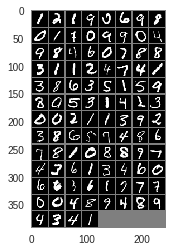

In [0]:
show_grid(data_loader)

In [0]:
def get_input_size(x):
  images,_=next(iter(x))
  return(images.shape[-1]*images.shape[-2])

In [0]:
class Discriminator(torch.nn.Module):

    def __init__(self,hidden_sizes):
        super(Discriminator, self).__init__()
        self.input_size=hidden_sizes[0]
        self.output_size=hidden_sizes[-1]

        hidden_layers = nn.ModuleList()
        
        for k in range(len(hidden_sizes)-1):
          hidden_layers.append(nn.Linear(hidden_sizes[k], hidden_sizes[k+1]))

          if(k<len(hidden_sizes)-2):
            hidden_layers.append(nn.Dropout(p=0.3))
            hidden_layers.append(nn.LeakyReLU(0.2))
        hidden_layers.append(nn.Sigmoid())
        self.net=nn.Sequential(*hidden_layers)
        
 
    def forward(self, x):
      return(self.net(x))


In [0]:
class Generator(torch.nn.Module):

    def __init__(self,hidden_sizes):
        super(Generator, self).__init__()
        self.input_size=hidden_sizes[0]
        self.output_size=hidden_sizes[-1]
        hidden_layers = nn.ModuleList()
        
        for k in range(len(hidden_sizes)-1):
          hidden_layers.append(nn.Linear(hidden_sizes[k], hidden_sizes[k+1]))

          if(k<len(hidden_sizes)-2):
            hidden_layers.append(nn.LeakyReLU(0.2))
        hidden_layers.append(nn.Tanh())
        self.net=nn.Sequential(*hidden_layers)
        
 
    def forward(self, x):
      x=x.to(device)
      return(self.net(x))

In [0]:
def get_hidden_sizes(input_size,hidden_sizes,output_size):
  hidden_sizes=np.insert(hidden_sizes,0,input_size)
  hidden_sizes=np.append(hidden_sizes,output_size)
  print(hidden_sizes)
  return(hidden_sizes)

In [0]:
hidden_sizes=get_hidden_sizes(get_input_size(data_loader),[1024,512,256],1)
dis_net=Discriminator(hidden_sizes).to(device)
hidden_sizes=get_hidden_sizes(batch_size,[256,512, 1024],get_input_size(data_loader))
gen_net=Generator(hidden_sizes).to(device)


epochs=200
steps=0
dis_loss_all=[]
gen_loss_all=[]
dis_optimizer = optim.Adam(dis_net.parameters(), lr=0.0001)
gen_optimizer = optim.Adam(gen_net.parameters(), lr=0.0001)
criterion  = nn.BCELoss()
snaps=[]

for e in range(epochs):
    for images,labels in data_loader:
      steps+=1
      dis_net.train()
      dis_optimizer.zero_grad()
      
      images=Variable(images.view(-1,dis_net.input_size)).to(device)
      dis_targets=Variable(torch.ones(images.shape[0],1),requires_grad=False).to(device)
      noise=Variable(torch.randn(images.shape[0], 100)).to(device)
      gen_net.eval()
      fake_images=gen_net(noise).detach()
      fake_targets=Variable(torch.zeros(fake_images.shape[0],1),requires_grad=False).to(device)
      
      #train Discriminator on real images
      dis_output_images=dis_net(images)
      dis_loss_images=criterion(dis_output_images,dis_targets)

      #train Discriminator on fake images
      dis_output_fakes=dis_net(fake_images)
      dis_loss_fakes=criterion(dis_output_fakes,fake_targets)     
      
      dis_loss=dis_loss_fakes+dis_loss_images
      dis_loss.backward()
      dis_loss_all.append(dis_loss.item())
      dis_optimizer.step()
      
      
      #train generator
      gen_optimizer.zero_grad()      
      noise=Variable(torch.randn(images.shape[0], 100)).to(device)
      fake_images=gen_net(noise)
      dis_net.eval()
      #feed the Discriminator fake images created by the generator, Discriminator is in eval mode
      gen_output_fakes=dis_net(fake_images)
      gen_net.train()
      gen_loss=criterion(gen_output_fakes,dis_targets)
      gen_loss.backward()
      gen_loss_all.append(gen_loss.item())
      gen_optimizer.step()
      
      
      if(steps%100==0):
        print(e,' ',steps,'dis_loss: ',dis_loss.item(),'gen_loss: ',gen_loss.item())
      if((steps)%len(data_loader)==0):
        gen_net.eval()
        with torch.no_grad():
          test_noise=Variable(torch.randn(images.shape[0], 100)).to(device)
          test_fake_images=gen_net(noise).view(-1,1,28,28).cpu()
          snaps.append(vutils.make_grid(test_fake_images, padding=2, normalize=True))
        gen_net.train()
      
      
      

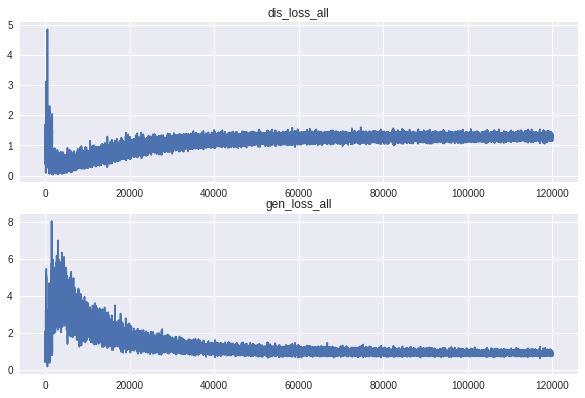

In [0]:
train_results=[dis_loss_all,gen_loss_all]
titles=['dis_loss_all','gen_loss_all']
fig = plt.figure(figsize=(10,10))
for i,data in enumerate(train_results):    
    plt.subplot(3,1, i+1)
    plt.plot(data)
    plt.title(titles[i])

In [0]:
fig = plt.figure(figsize=(5,5))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in snaps]
ani = animation.ArtistAnimation(fig, ims, interval=500, repeat_delay=1000, blit=True);
plt.close()
HTML(ani.to_html5_video())
